# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [50]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [51]:
## Load the data into a DataFrame
csv_filepath = '/Users/kristensu/downloads/Iowa_Liquor_sales_sample_10pct.csv'
iowa = pd.read_csv(csv_filepath)

In [ ]:
iowa.head(3)

In [ ]:
iowa.dtypes

In [ ]:
print iowa.columns
print iowa.shape

# Clean Data

### Drop duplicate (unnecessary) columns

In [52]:
# Drop cols that contain same info as another col
iowa.drop(['County Number', 'Item Number', 'Volume Sold (Gallons)'], axis=1, inplace=True)

In [53]:
# Made a separate df for category to category name mapping for future reference
category_df = pd.pivot_table(iowa, index=['Category', 'Category Name'], values=['Bottles Sold'])
category_df.drop('Bottles Sold', axis=1, inplace=True)
category_df.head(2)

,
Category,Category Name
1011100.0,BLENDED WHISKIES
1011200.0,STRAIGHT BOURBON WHISKIES


### Clean column names

In [54]:
# Clean column name 1: Rename columns
iowa.rename(columns={'Store Number':'Store', 'Bottle Volume (ml)':'Bottle Volume', 'Sale (Dollars)':'Sales', \
               'Volume Sold (Liters)':'Volume Sold'}, inplace=True)

# Clean column names 2: Change all column names to lowercase letters
iowa.rename(columns=lambda x: x.lower(), inplace=True)

# Clean column names 3: Replace ' ' with '_'
iowa.rename(columns=lambda x: x.replace(" ","_"), inplace=True)


### Clean values in columns with currency and date

In [55]:
# Convert columns with dollar amounts from object to numeric float
currency = ['sales', 'state_bottle_cost', 'state_bottle_retail']
iowa[currency] = iowa[currency].apply(lambda x: x.str.replace('$',''))
iowa[currency] = iowa[currency].apply(lambda x: x.str.replace(',',''))
iowa[currency] = iowa[currency].apply(lambda x: pd.to_numeric(x))

In [56]:
# Convert date from object to datetime
iowa['date'] = pd.to_datetime(iowa['date'])

In [57]:
iowa.head(3)

,date,store,city,zip_code,county,category,category_name,vendor_number,item_description,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sales,volume_sold
0,2015-11-04,3717,SUMNER,50674,Bremer,1051100.0,APRICOT BRANDIES,55,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0
1,2016-03-02,2614,DAVENPORT,52807,Scott,1011100.0,BLENDED WHISKIES,395,Tin Cup,750,13.75,20.63,2,41.26,1.5
2,2016-02-11,2106,CEDAR FALLS,50613,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,Jim Beam,1000,12.59,18.89,24,453.36,24.0


In [61]:
# Convert zip code to int
print iowa['zip_code'].nunique()
print iowa['zip_code'].unique()
# One problematic value: 712-2

In [59]:
# Drop problematic zip code and convert rest to int
iowa['zip_code'] = pd.to_numeric(iowa["zip_code"], errors='coerce')
iowa.fillna(np.nan)
iowa['zip_code'].dropna().astype(int)
iowa['zip_code'].head(2)

0    50674.0
1    52807.0
Name: zip_code, dtype: float64

In [62]:
iowa.isnull().sum()

date                      0
store                     0
city                      0
zip_code                217
county                 1077
category                 68
category_name           632
vendor_number             0
item_description          0
bottle_volume             0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sales                     0
volume_sold               0
dtype: int64

In [15]:
iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 15 columns):
date                   270955 non-null datetime64[ns]
store                  270955 non-null int64
city                   270955 non-null object
zip_code               270738 non-null float64
county                 270955 non-null object
category               270887 non-null float64
category_name          270955 non-null object
vendor_number          270955 non-null int64
item_description       270955 non-null object
bottle_volume          270955 non-null int64
state_bottle_cost      270955 non-null float64
state_bottle_retail    270955 non-null float64
bottles_sold           270955 non-null int64
sales                  270955 non-null float64
volume_sold            270955 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(4), object(4)
memory usage: 31.0+ MB


### Convert dtype object to str

In [48]:
iowa['city'] = iowa['city'].astype(object)
iowa['county'] = iowa['county'].astype(object)
iowa['category_name'] = iowa['category_name'].astype(object)
iowa['item_description'] = iowa['item_description'].astype(object)

### Extract dates into year, quarter and month

In [63]:
def extract_month(x):
    month = str('{:02d}'.format(x.month)) + "-" + str((x.year))
    return month
def extract_quarter(x):
    quarter = "Q" + str(x.quarter) + "-" + str(x.year)
    return quarter

iowa["year"] = iowa["date"].dt.year
iowa["quarter"] = iowa["date"].apply(extract_quarter)
iowa["month"] = iowa["date"].apply(extract_month)

### Check for and replace NaNs

In [64]:
iowa.isnull().sum()
#Will leave zip_code NaNs as I filled problematic zip code with np.nan above

date                      0
store                     0
city                      0
zip_code                217
county                 1077
category                 68
category_name           632
vendor_number             0
item_description          0
bottle_volume             0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sales                     0
volume_sold               0
year                      0
quarter                   0
month                     0
dtype: int64

### Remove Duplicate County Names & Fill in Missing Counties

In [65]:
# Match missing County with City
df_county = pd.pivot_table(iowa, index=['city', 'county'], values=['sales'], aggfunc=sum)
df_county.drop('sales', axis=1, inplace=True)
df_county.reset_index(inplace=True)
df_county.head()

,city,county
0,ACKLEY,Hardin
1,ACKLEY,Webster
2,ADAIR,Adair
3,ADEL,Dallas
4,AFTON,Union


In [66]:
print df_county['city'].duplicated().sum()
a = df_county[df_county['city'].duplicated() == True].index.tolist()
df_county['city'].loc[a]

11


1               ACKLEY
33          BETTENDORF
66               CLIVE
74             CORNING
135         FORT DODGE
260             NEWTON
264      NORTH LIBERTY
277          OSKALOOSA
289              PERRY
337       STATE CENTER
380    WEST DES MOINES
Name: city, dtype: object

In [67]:
# Did not use drop_duplicates() because I did not want to automatically drop the second duplicate
# So I checked the counties of duplicate cities and dropped incorrect city-county mappings
# It also turns out some towns (Ackley, Clive, and West Des Moines are located in multiple counties)
# Remove from iowa dataframe: index [32, 74, 134, 260, 263, 276, 288, 336]

b = [i+1 for i in a]
c = [i-1 for i in a]
d = a + b + c
e = sorted(d)

df_county.loc[e, :]
county_dict = {'bettendorf':'scott', 'corning':'adams', 'fort dodge': 'webster','newton':'jasper', \
               'north libery':'johnson', 'OSKALOOSA': 'mahaska', 'PERRY':'dallas', 'STATE CENTER': 'marshall'}

In [68]:
# Remove from iowa dataframe: index [32, 74, 134, 260, 263, 276, 288, 336]
df_county.drop([32, 74, 134, 260, 263, 276, 288, 336], inplace=True)

# Rename Ackley, Clive, and West Des Moines to account for parts of town in different counties
df_county.set_value([1,66,380], 'city', ['ACKLEY_WEBSTER', 'CLIVE_POLK', 'WEST_DES_MOINES_POLK'])

,city,county
0,ACKLEY,Hardin
1,ACKLEY_WEBSTER,Webster
2,ADAIR,Adair
3,ADEL,Dallas
4,AFTON,Union
5,AKRON,Plymouth
6,ALBIA,Monroe
7,ALDEN,Hardin
8,ALGONA,Kossuth
9,ALLISON,Butler


In [69]:
# Merge df_county into original iowa df
# Note: Original "county" renamed "county_x" and new "county_y" col created
iowa = pd.merge(iowa,df_county, on = 'city', how = 'left')
iowa.head(3)

,date,store,city,zip_code,county_x,category,category_name,vendor_number,item_description,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sales,volume_sold,year,quarter,month,county_y
0,2015-11-04,3717,SUMNER,50674.0,Bremer,1051100.0,APRICOT BRANDIES,55,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2015,Q4-2015,11-2015,Bremer
1,2016-03-02,2614,DAVENPORT,52807.0,Scott,1011100.0,BLENDED WHISKIES,395,Tin Cup,750,13.75,20.63,2,41.26,1.5,2016,Q1-2016,03-2016,Scott
2,2016-02-11,2106,CEDAR FALLS,50613.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,Jim Beam,1000,12.59,18.89,24,453.36,24.0,2016,Q1-2016,02-2016,Black Hawk


In [70]:
# Fill missing county names in "county_x" with county names from "county_y"
iowa['county_x'].fillna(iowa['county_y'], inplace=True)
iowa.isnull().sum()

date                     0
store                    0
city                     0
zip_code               217
county_x                12
category                68
category_name          632
vendor_number            0
item_description         0
bottle_volume            0
state_bottle_cost        0
state_bottle_retail      0
bottles_sold             0
sales                    0
volume_sold              0
year                     0
quarter                  0
month                    0
county_y                12
dtype: int64

In [71]:
# Check for remaining missing counties
iowa[iowa["county_x"].isnull()]['city'].unique()

array(['TABOR', 'SEYMOUR', 'RUNNELLS'], dtype=object)

In [72]:
# Fill in missing counties by mapping to city
def county_name(city):
    if city == "TABOR":
        return "Fremont"
    elif city == "SEYMOUR":
        return "Wayne"
    elif city == "RUNNELLS":
        return "Polk"
    else:
        pass

iowa['county_y'] = iowa['city'].apply(county_name)
iowa['county_x'].fillna(iowa['county_y'], inplace=True)

In [73]:
iowa.isnull().sum()

date                        0
store                       0
city                        0
zip_code                  217
county_x                    0
category                   68
category_name             632
vendor_number               0
item_description            0
bottle_volume               0
state_bottle_cost           0
state_bottle_retail         0
bottles_sold                0
sales                       0
volume_sold                 0
year                        0
quarter                     0
month                       0
county_y               270943
dtype: int64

### Drop Missing Values in "category_name"

In [75]:
# Find duplicates in category name
df_category_name = pd.pivot_table(iowa,index = ['item_description','category_name'], \
                                  values = ['sales'], aggfunc = sum)
df_category_name.reset_index(inplace = True)
df_category_name.drop('sales', axis=1, inplace=True)
df_category_name.duplicated().sum()
# No duplicates

0

In [76]:
iowa['category'].isnull().sum()

68

In [78]:
# Drop rows with NaN in "category_name" col as it is only 0.233% of total 
# Did not have the time (as I did for counties above) to go through the 632 NaN rows
null_cat_percent = (iowa['category_name'].isnull().sum())/ \
                    float(len(iowa['category_name']))*100
print str(round(null_cat_percent, 3)) + '% of total rows ' + 'is null'
print 'These 632 rows will be dropped from analysis'

iowa.dropna(subset=[['category_name']], inplace=True)
iowa[['category_name']].head(3)

0.0% of total rows is null
These 632 rows will be dropped from analysis


,category_name
0,APRICOT BRANDIES
1,BLENDED WHISKIES
2,STRAIGHT BOURBON WHISKIES


In [79]:
iowa.isnull().sum()

date                        0
store                       0
city                        0
zip_code                  216
county_x                    0
category                    0
category_name               0
vendor_number               0
item_description            0
bottle_volume               0
state_bottle_cost           0
state_bottle_retail         0
bottles_sold                0
sales                       0
volume_sold                 0
year                        0
quarter                     0
month                       0
county_y               270311
dtype: int64

In [80]:
# Drop county_y column and rename county_x as county
iowa.drop('county_y', axis=1, inplace=True)
iowa.rename(columns={'county_x':'county'}, inplace=True)

In [81]:
iowa.head(3)

,date,store,city,zip_code,county,category,category_name,vendor_number,item_description,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sales,volume_sold,year,quarter,month
0,2015-11-04,3717,SUMNER,50674.0,Bremer,1051100.0,APRICOT BRANDIES,55,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2015,Q4-2015,11-2015
1,2016-03-02,2614,DAVENPORT,52807.0,Scott,1011100.0,BLENDED WHISKIES,395,Tin Cup,750,13.75,20.63,2,41.26,1.5,2016,Q1-2016,03-2016
2,2016-02-11,2106,CEDAR FALLS,50613.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,Jim Beam,1000,12.59,18.89,24,453.36,24.0,2016,Q1-2016,02-2016


In [82]:
january = iowa[iowa['month'] == '01-2015']
january2 = iowa[iowa['month'] == '01-2016']
y = sum(january['sales'])
x = sum(january2['sales']) - sum(january['sales'])
jan_growth = x/y*100
print 'Sales growth Jan 16: ' + str(round(jan_growth,2)) + '%'


Sales growth Jan 16: 1.19%


### Create new columns with metrics

In [83]:
# Just checking to make that that the 'sales' columns represents total revenue
iowa['sales_check'] = iowa['state_bottle_retail'] * iowa['bottles_sold']
print sum(iowa['sales_check']-iowa['sales'])
iowa.drop('sales_check', axis=1, inplace=True)

2.71302980082e-11


In [84]:
# New metrics added to iowa
iowa['profit'] = (iowa['state_bottle_retail'] - iowa['state_bottle_cost']) * iowa['bottles_sold']
iowa['rev_per_ml'] = iowa['sales'] / iowa['volume_sold']
iowa['price_per_ml'] = iowa['state_bottle_retail'] / iowa['volume_sold']
iowa['margin_percent'] = iowa['profit'] / iowa['sales']
iowa['profit_per_ml'] = iowa['profit'] / iowa['volume_sold']
iowa['profit_%_per_ml'] = iowa['profit_per_ml'] / iowa['rev_per_ml']

In [85]:
print 'Iowa is a "control state", meaning the state has direct control over the wholesale alcohol \
market. The state dictates retail prices at a set margin of 33.3%.'
print 'See Iowa Alcoholic Beverages Division for more info.'
iowa.iloc[:3,11:28]

Iowa is a "control state", meaning the state has direct control over the wholesale alcohol market. The state dictates retail prices at a set margin of 33.3%.
See Iowa Alcoholic Beverages Division for more info.


,state_bottle_retail,bottles_sold,sales,volume_sold,year,quarter,month,profit,rev_per_ml,price_per_ml,margin_percent,profit_per_ml,profit_%_per_ml
0,6.75,12,81.00,9.0,2015,Q4-2015,11-2015,27.00,9.000000,0.750000,0.333333,3.000000,0.333333
1,20.63,2,41.26,1.5,2016,Q1-2016,03-2016,13.76,27.506667,13.753333,0.333495,9.173333,0.333495
2,18.89,24,453.36,24.0,2016,Q1-2016,02-2016,151.20,18.890000,0.787083,0.333510,6.300000,0.333510


In [86]:
# Drop margin % columns (they are constant and will not affect model)
iowa.drop(['margin_percent', 'profit_%_per_ml'], inplace=True,axis=1)

# Add margin per bottle as this is not a constant measure
iowa['profit_per_bottle'] = iowa['state_bottle_retail'] - iowa['state_bottle_cost']
iowa.iloc[:2,11:28]

,state_bottle_retail,bottles_sold,sales,volume_sold,year,quarter,month,profit,rev_per_ml,price_per_ml,profit_per_ml,profit_per_bottle
0,6.75,12,81.00,9.0,2015,Q4-2015,11-2015,27.00,9.000000,0.750000,3.000000,2.25
1,20.63,2,41.26,1.5,2016,Q1-2016,03-2016,13.76,27.506667,13.753333,9.173333,6.88


### Drop stores that were only partially open in 2015

In [87]:
# Check for stores that were not open for the full year or closed during the year
dates_open = iowa.groupby(["store"])["date"].agg([min, max])
dates_open.reset_index(inplace=True)
dates_open.tail(3)

,store,min,max
1397,9013,2015-06-04,2016-03-09
1398,9018,2015-10-27,2015-10-27
1399,9023,2016-03-08,2016-03-08


In [88]:
def open_date(x):
    if x > pd.to_datetime('2015-03-31'):
        return 1
    else:
        return 0
    
def close_date(x):
    if x <= pd.to_datetime('2015-12-31'):
        return 1
    else:
        return 0
    
dates_open["closed"] = dates_open["max"].apply(close_date)
dates_open["opened"] = dates_open["min"].apply(open_date)
dates_open["partial_year"] = dates_open["closed"] + dates_open["opened"]

In [ ]:
dates_open.tail(3)

In [89]:
# List of 217 stores not open full year in 2015
partial_stores = list(dates_open[dates_open["partial_year"]!=0]["store"].values)
print 'Number of stores not open for full year 2015: ' + str(len(partial_stores))

open_stores = list(dates_open[dates_open['partial_year'] == 0]['store'].values)
print 'Total stores: '+ str(len(partial_stores) + len(open_stores))
print 'Total stores open all of 2015: ' + str(len(open_stores))


Number of stores not open for full year 2015: 217
Total stores: 1400
Total stores open all of 2015: 1183


In [90]:
# Amount of revenue generated by stores only partially open in 2015
partial_rev = sum(iowa[iowa['store'].isin(partial_stores)]['sales']) / sum(iowa['sales']) 
print 'Only ' + str(round(partial_rev*100,2)) + '% of sales from stores partially open in 2015'
print 'Sales from these 217 stores will be dropped from analysis'

Only 3.73% of sales from stores partially open in 2015
Sales from these 217 stores will be dropped from analysis


## Create a new df with only stores open for full year 2015

In [91]:
# Create new df consisting only of stores open for full year 2015
idf = iowa[iowa['store'].isin(open_stores)]

## Create a new df summarizing 2015 data only

In [92]:
# Create a df summarizing total sales and revenues in 2015 at store-level
sum_metrics = ['sales', 'volume_sold', 'bottles_sold']
iowa_sum_2015 = idf[idf['year'] == 2015].groupby(['store'])[sum_metrics].agg(np.sum)
iowa_sum_2015.columns = ['2015_total_rev','2015_bottles_sold', '2015_vol_sold']
iowa_sum_2015.reset_index(inplace=True)
print len(iowa_sum_2015)
iowa_sum_2015.describe(include='all')

1183


,store,2015_total_rev,2015_bottles_sold,2015_vol_sold
count,1183.000000,1183.000000,1183.000000,1183.000000
mean,4165.122570,23218.195748,1616.755680,1762.295013
std,812.526287,54099.137842,3421.465445,3427.349652
min,2106.000000,450.010000,21.630000,36.000000
25%,3805.500000,3897.355000,280.600000,365.500000
50%,4376.000000,8407.240000,630.280000,764.000000
75%,4740.500000,21844.450000,1593.975000,1848.000000
max,9010.000000,997924.420000,61831.750000,62827.000000


In [93]:
# Create a df summarizing mean metrics for 2015 at store-level
mean_metrics = ['sales', 'bottles_sold', 'volume_sold', 'price_per_ml', 'profit_per_ml', 'profit_per_bottle']
iowa_mean_2015 = idf[idf['year'] == 2015].groupby(['store'])[mean_metrics].agg(np.mean)
iowa_mean_2015.columns = ['2015_avg_rev','2015_avg_bott_sold', '2015_avg_vol', '2015_avg_price_per_ml', \
                         '2015_avg_profit_per_ml', '2015_avg_profit_per_bottle']
iowa_mean_2015.reset_index(inplace=True)
print len(iowa_mean_2015)
iowa_mean_2015.describe(include='all')

1183


,store,2015_avg_rev,2015_avg_bott_sold,2015_avg_vol,2015_avg_price_per_ml,2015_avg_profit_per_ml,2015_avg_profit_per_bottle
count,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000
mean,4165.122570,123.926313,10.560021,8.964779,4.714215,5.685850,4.564185
std,812.526287,117.577581,6.827043,7.096459,2.914395,1.249910,0.988594
min,2106.000000,24.757826,2.169600,1.692663,0.543021,3.173605,1.488667
25%,3805.500000,76.632554,6.782909,5.655741,2.198975,4.945446,3.935385
50%,4376.000000,106.078333,9.575000,7.821006,4.280716,5.537004,4.540980
75%,4740.500000,143.660356,12.392333,10.500000,6.397115,6.228304,5.098574
max,9010.000000,2061.811833,87.266667,108.200000,19.266372,27.428178,11.653750


In [94]:
# Create a df showing all days with sales for each store
idf_open = idf.loc[:,['store', 'date', 'year', 'quarter']]
idf_open.drop_duplicates(['store', 'date'], inplace=True)
idf.sort_values('store').head()

days_open_15 = idf_open[idf_open['year'] == 2015].groupby(['store'])[['date']].agg(len)
days_open_15.reset_index(inplace=True)
days_open_15.columns = ['store', 'days_open_15']
days_open_15['days_open_15'] = days_open_15['days_open_15'].astype(int)

In [95]:
# Create daily metrics (rev_per_day and profit_per_day) with days_open data 
iowa_sum_2015['2015_rev_per_day'] = iowa_sum_2015['2015_total_rev'] / days_open_15['days_open_15']
iowa_sum_2015['2015_bott_per_day'] = iowa_sum_2015['2015_bottles_sold'] / days_open_15['days_open_15']
iowa_sum_2015['2015_vol_per_day'] = iowa_sum_2015['2015_vol_sold'] / days_open_15['days_open_15']
iowa_sum_2015.head()

,store,2015_total_rev,2015_bottles_sold,2015_vol_sold,2015_rev_per_day,2015_bott_per_day,2015_vol_per_day
0,2106,146038.70,9719.85,10355,2808.436538,186.920192,199.134615
1,2113,9310.22,659.85,671,198.089787,14.039362,14.276596
2,2130,111583.91,6879.37,7418,2145.844423,132.295577,142.653846
3,2152,7721.08,633.37,573,157.573061,12.925918,11.693878
4,2178,24324.18,1917.12,1928,476.944706,37.590588,37.803922


In [99]:
# Create df of categorical variables only 
idf_category = idf.loc[:,['store', 'city', 'county', 'zip_code']].drop_duplicates()

# Merge (left join) iowa_sum, iowa_mean and days_open_15 to create df of all stores for 2015 data 
idf_2015 = pd.merge(idf_category, days_open_15, how='left', on='store'). \
merge(iowa_sum_2015, how='left', on='store').merge(iowa_mean_2015, how='left', on='store')
idf_2015.drop_duplicates(inplace=True)
print len(idf_2015)
print 'Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.'
idf_2015.head(3)

1185
Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.


,store,city,county,zip_code,days_open_15,2015_total_rev,2015_bottles_sold,2015_vol_sold,2015_rev_per_day,2015_bott_per_day,2015_vol_per_day,2015_avg_rev,2015_avg_bott_sold,2015_avg_vol,2015_avg_price_per_ml,2015_avg_profit_per_ml,2015_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,50,9022.86,685.53,632,180.457200,13.710600,12.640000,34.438397,2.412214,2.616527,10.623053,5.389800,5.103779
1,2614,DAVENPORT,Scott,52807.0,52,142675.29,9868.23,10051,2743.755577,189.773654,193.288462,138.385344,9.748788,9.571513,7.146836,6.427207,5.232396
2,2106,CEDAR FALLS,Black Hawk,50613.0,52,146038.70,9719.85,10355,2808.436538,186.920192,199.134615,277.640114,19.686312,18.478802,2.790379,5.957151,5.160951


In [100]:
idf_2015.duplicated().sum()

0

## Create a new df summarzing Q1-2015 data only

In [101]:
# Create a df summarizing total sales and revenues in 2015 at store-level
iowa_sum_2015Q1 = idf[idf['quarter'] == 'Q1-2015'].groupby(['store'])[sum_metrics].agg(np.sum)
iowa_sum_2015Q1.columns = ['Q1-15_total_revenue','Q1-15_bott', 'Q1-15_vol']
iowa_sum_2015Q1.reset_index(inplace=True)
print len(iowa_sum_2015Q1)

# Create a df summarizing mean metrics
mean_metrics = ['sales', 'bottles_sold', 'volume_sold', 'price_per_ml', 'profit_per_ml', 'profit_per_bottle']
iowa_mean_2015Q1 = idf[idf['quarter'] == 'Q1-2015'].groupby(['store'])[mean_metrics].agg(np.mean)
iowa_mean_2015Q1.columns = ['Q1-15_avg_rev','Q1-15_avg_bott','Q1-15_avg_vol', 'Q1-15_avg_price_per_ml', \
                         'Q1-15_avg_profit_per_ml', 'Q1-15_avg_profit_per_bottle']
iowa_mean_2015Q1.reset_index(inplace=True)
print len(iowa_mean_2015Q1)

# Create days_open df for Q1-2015
days_open_15Q1 = idf_open[idf_open['quarter'] == 'Q1-2015'].groupby(['store'])[['date']].agg(len)
days_open_15Q1.reset_index(inplace=True)
days_open_15Q1.columns = ['store', 'days_open_15Q1']
days_open_15Q1['days_open_15Q1'] = days_open_15Q1['days_open_15Q1'].astype(int)

1183
1183


In [102]:
# Create daily metrics (rev_per_day and profit_per_day) with days_open data 
iowa_sum_2015Q1['rev_per_day_15Q1'] = iowa_sum_2015Q1['Q1-15_total_revenue'] / days_open_15Q1['days_open_15Q1']
iowa_sum_2015Q1['bott_per_day_15Q1'] = iowa_sum_2015Q1['Q1-15_bott'] / days_open_15Q1['days_open_15Q1']
iowa_sum_2015Q1['vol_per_day_15Q1'] = iowa_sum_2015Q1['Q1-15_vol'] / days_open_15Q1['days_open_15Q1']
iowa_sum_2015Q1.head()

,store,Q1-15_total_revenue,Q1-15_bott,Q1-15_vol,rev_per_day_15Q1,bott_per_day_15Q1,vol_per_day_15Q1
0,2106,39287.29,2526.10,2705,3273.940833,210.508333,225.416667
1,2113,2833.25,177.11,196,257.568182,16.100909,17.818182
2,2130,24272.57,1447.25,1533,2022.714167,120.604167,127.750000
3,2152,2003.46,151.74,154,166.955000,12.645000,12.833333
4,2178,5856.41,409.81,490,488.034167,34.150833,40.833333


In [103]:
# Merge (left join) iowa_sum, iowa_mean and days_open_15 to create df of all stores for 2015 data 
idf_2015Q1 = pd.merge(idf_category, days_open_15Q1, how='left', on='store')
idf_2015Q1 = pd.merge(idf_2015Q1,iowa_sum_2015Q1, how='left', on='store'). \
merge(iowa_mean_2015Q1, how='left', on='store')

print len(idf_2015Q1)
print 'Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.'
idf_2015Q1.head(3)

1185
Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.


,store,city,county,zip_code,days_open_15Q1,Q1-15_total_revenue,Q1-15_bott,Q1-15_vol,rev_per_day_15Q1,bott_per_day_15Q1,vol_per_day_15Q1,Q1-15_avg_rev,Q1-15_avg_bott,Q1-15_avg_vol,Q1-15_avg_price_per_ml,Q1-15_avg_profit_per_ml,Q1-15_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,11,1583.13,117.35,112,143.920909,10.668182,10.181818,35.980227,2.545455,2.667045,11.149558,5.540246,4.902955
1,2614,DAVENPORT,Scott,52807.0,12,32260.12,1978.11,2276,2688.343333,164.842500,189.666667,135.546723,9.563025,8.311387,5.584630,5.687667,4.805462
2,2106,CEDAR FALLS,Black Hawk,50613.0,12,39287.29,2526.10,2705,3273.940833,210.508333,225.416667,304.552636,20.968992,19.582171,3.432935,5.959059,5.033721


## Create a new df summarzing Q1-2016 data only

In [104]:
# Create a df summarizing total sales and revenues in 2016 at store-level
iowa_sum_2016Q1 = idf[idf['quarter'] == 'Q1-2016'].groupby(['store'])[sum_metrics].agg(np.sum)
iowa_sum_2016Q1.columns = ['Q1-16_total_revenue','Q1-16_bott', 'Q1-16_vol']
iowa_sum_2016Q1.reset_index(inplace=True)
print len(iowa_sum_2016Q1)

# Create a df summarizing mean metrics
mean_metrics = ['sales', 'profit', 'volume_sold', 'price_per_ml', 'profit_per_ml', 'profit_per_bottle']
iowa_mean_2016Q1 = idf[idf['quarter'] == 'Q1-2016'].groupby(['store'])[mean_metrics].agg(np.mean)
iowa_mean_2016Q1.columns = ['Q1-16_avg_rev','Q1-16_avg_bott', 'Q1-16_avg_vol', 'Q1-16_avg_price_per_ml', \
                         'Q1-16_avg_profit_per_ml', 'Q1-16_avg_profit_per_bottle']
iowa_mean_2016Q1.reset_index(inplace=True)
print len(iowa_mean_2016Q1)

# Create days_open df for Q1-2016
days_open_16Q1 = idf_open[idf_open['quarter'] == 'Q1-2016'].groupby(['store'])[['date']].agg(len)
days_open_16Q1.reset_index(inplace=True)
days_open_16Q1.columns = ['store', 'days_open_16Q1']
days_open_16Q1['days_open_16Q1'] = days_open_16Q1['days_open_16Q1'].astype(int)

1183
1183


In [105]:
# Create daily metrics (rev_per_day and profit_per_day) with days_open data 
iowa_sum_2016Q1['rev_per_day_16Q1'] = iowa_sum_2016Q1['Q1-16_total_revenue'] / days_open_16Q1['days_open_16Q1']
iowa_sum_2016Q1['bott_per_day_16Q1'] = iowa_sum_2016Q1['Q1-16_bott'] / days_open_16Q1['days_open_16Q1']
iowa_sum_2016Q1['vol_per_day_16Q1'] = iowa_sum_2016Q1['Q1-16_vol'] / days_open_16Q1['days_open_16Q1']

# Merge (left join) iowa_sum, iowa_mean and days_open_15 to create df of all stores for 2016 data 
idf_2016Q1 = pd.merge(idf_category, days_open_16Q1, how='left', on='store')
idf_2016Q1 = pd.merge(idf_2016Q1,iowa_sum_2016Q1, how='left', on='store'). \
merge(iowa_mean_2016Q1, how='left', on='store')

idf_2016Q1.head(3)
print len(idf_2016Q1)
print 'Note: discrepancy between len(idf) and len(idf_2016) result of 2 stores each counted twice. No time to remove.'
idf_2016Q1.head(3)

1185
Note: discrepancy between len(idf) and len(idf_2016) result of 2 stores each counted twice. No time to remove.


,store,city,county,zip_code,days_open_16Q1,Q1-16_total_revenue,Q1-16_bott,Q1-16_vol,rev_per_day_16Q1,bott_per_day_16Q1,vol_per_day_16Q1,Q1-16_avg_rev,Q1-16_avg_bott,Q1-16_avg_vol,Q1-16_avg_price_per_ml,Q1-16_avg_profit_per_ml,Q1-16_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,13,2510.46,187.00,169,193.112308,14.384615,13.000000,34.867500,11.632917,2.597222,10.805656,5.511753,5.455972
1,2614,DAVENPORT,Scott,52807.0,13,36360.48,2955.61,2723,2796.960000,227.354615,209.461538,133.188571,44.436337,10.826410,7.705376,6.472363,5.056520
2,2106,CEDAR FALLS,Black Hawk,50613.0,13,30478.75,2116.25,2218,2344.519231,162.788462,170.615385,241.894841,80.751429,16.795635,3.686858,5.997147,5.196508


In [106]:
# Make sure all three new dfs are shame shape
print idf_2015.shape
print idf_2015Q1.shape
print idf_2016Q1.shape

(1185, 17)
(1185, 17)
(1185, 17)


In [107]:
###################################################
a1 = idf_2015.copy()
a2 = idf_2015Q1.copy()
a3 = idf_2016Q1.copy()

## Merge 2015, Q1-2015 and Q2-2015 dfs

In [108]:
stores_df = idf_2015.merge(idf_2015Q1, on=['store', 'county', 'city', 'zip_code'], how ='left')\
.merge(idf_2016Q1, on= ['store', 'county', 'city', 'zip_code'], how ="left")

In [109]:
print stores_df.shape
print pd.DataFrame(stores_df.columns)
stores_df.head(3)

(1185, 43)
                              0
0                         store
1                          city
2                        county
3                      zip_code
4                  days_open_15
5                2015_total_rev
6             2015_bottles_sold
7                 2015_vol_sold
8              2015_rev_per_day
9             2015_bott_per_day
10             2015_vol_per_day
11                 2015_avg_rev
12           2015_avg_bott_sold
13                 2015_avg_vol
14        2015_avg_price_per_ml
15       2015_avg_profit_per_ml
16   2015_avg_profit_per_bottle
17               days_open_15Q1
18          Q1-15_total_revenue
19                   Q1-15_bott
20                    Q1-15_vol
21             rev_per_day_15Q1
22            bott_per_day_15Q1
23             vol_per_day_15Q1
24                Q1-15_avg_rev
25               Q1-15_avg_bott
26                Q1-15_avg_vol
27       Q1-15_avg_price_per_ml
28      Q1-15_avg_profit_per_ml
29  Q1-15_avg_profit_per_bott

,store,city,county,zip_code,days_open_15,2015_total_rev,2015_bottles_sold,2015_vol_sold,2015_rev_per_day,2015_bott_per_day,...,Q1-16_vol,rev_per_day_16Q1,bott_per_day_16Q1,vol_per_day_16Q1,Q1-16_avg_rev,Q1-16_avg_bott,Q1-16_avg_vol,Q1-16_avg_price_per_ml,Q1-16_avg_profit_per_ml,Q1-16_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,50,9022.86,685.53,632,180.457200,13.710600,...,169,193.112308,14.384615,13.000000,34.867500,11.632917,2.597222,10.805656,5.511753,5.455972
1,2614,DAVENPORT,Scott,52807.0,52,142675.29,9868.23,10051,2743.755577,189.773654,...,2723,2796.960000,227.354615,209.461538,133.188571,44.436337,10.826410,7.705376,6.472363,5.056520
2,2106,CEDAR FALLS,Black Hawk,50613.0,52,146038.70,9719.85,10355,2808.436538,186.920192,...,2218,2344.519231,162.788462,170.615385,241.894841,80.751429,16.795635,3.686858,5.997147,5.196508


In [115]:
# Create new column for sales and profit for Q2-Q4 2015

stores_df['2015-Q2-Q4_rev'] = stores_df['2015_total_rev'] - stores_df['Q1-15_total_revenue']
stores_df['2015-Q2-Q4_bott'] = stores_df['2015_bottles_sold'] - stores_df['Q1-15_bott']
stores_df['2015-Q2-Q4_vol'] = stores_df['2015_vol_sold'] - stores_df['Q1-15_vol']
stores_df.head(3)

,store,city,county,zip_code,days_open_15,2015_total_rev,2015_bottles_sold,2015_vol_sold,2015_rev_per_day,2015_bott_per_day,...,vol_per_day_16Q1,Q1-16_avg_rev,Q1-16_avg_bott,Q1-16_avg_vol,Q1-16_avg_price_per_ml,Q1-16_avg_profit_per_ml,Q1-16_avg_profit_per_bottle,2015-Q2-Q4_rev,2015-Q2-Q4_bott,2015-Q2-Q4_vol
0,3717,SUMNER,Bremer,50674.0,50,9022.86,685.53,632,180.457200,13.710600,...,13.000000,34.867500,11.632917,2.597222,10.805656,5.511753,5.455972,7439.73,568.18,520
1,2614,DAVENPORT,Scott,52807.0,52,142675.29,9868.23,10051,2743.755577,189.773654,...,209.461538,133.188571,44.436337,10.826410,7.705376,6.472363,5.056520,110415.17,7890.12,7775
2,2106,CEDAR FALLS,Black Hawk,50613.0,52,146038.70,9719.85,10355,2808.436538,186.920192,...,170.615385,241.894841,80.751429,16.795635,3.686858,5.997147,5.196508,106751.41,7193.75,7650


## Data Exploration

In [116]:
stores_df.columns

Index([u'store', u'city', u'county', u'zip_code', u'days_open_15',
       u'2015_total_rev', u'2015_bottles_sold', u'2015_vol_sold',
       u'2015_rev_per_day', u'2015_bott_per_day', u'2015_vol_per_day',
       u'2015_avg_rev', u'2015_avg_bott_sold', u'2015_avg_vol',
       u'2015_avg_price_per_ml', u'2015_avg_profit_per_ml',
       u'2015_avg_profit_per_bottle', u'days_open_15Q1',
       u'Q1-15_total_revenue', u'Q1-15_bott', u'Q1-15_vol',
       u'rev_per_day_15Q1', u'bott_per_day_15Q1', u'vol_per_day_15Q1',
       u'Q1-15_avg_rev', u'Q1-15_avg_bott', u'Q1-15_avg_vol',
       u'Q1-15_avg_price_per_ml', u'Q1-15_avg_profit_per_ml',
       u'Q1-15_avg_profit_per_bottle', u'days_open_16Q1',
       u'Q1-16_total_revenue', u'Q1-16_bott', u'Q1-16_vol',
       u'rev_per_day_16Q1', u'bott_per_day_16Q1', u'vol_per_day_16Q1',
       u'Q1-16_avg_rev', u'Q1-16_avg_bott', u'Q1-16_avg_vol',
       u'Q1-16_avg_price_per_ml', u'Q1-16_avg_profit_per_ml',
       u'Q1-16_avg_profit_per_bottle', u'2015-Q

In [117]:
metrics_2015Q1 = ['days_open_15Q1',
       'Q1-15_total_revenue', 'Q1-15_bott', 'Q1-15_vol', 'rev_per_day_15Q1',
       'bott_per_day_15Q1', 'vol_per_day_15Q1', 'Q1-15_avg_rev', 'Q1-15_avg_bott',
       'Q1-15_avg_vol', 'Q1-15_avg_price_per_ml', 'Q1-15_avg_profit_per_ml',
       'Q1-15_avg_profit_per_bottle']

In [118]:
stores_df.loc[:,metrics_2015Q1].corr()

,days_open_15Q1,Q1-15_total_revenue,Q1-15_bott,Q1-15_vol,rev_per_day_15Q1,bott_per_day_15Q1,vol_per_day_15Q1,Q1-15_avg_rev,Q1-15_avg_bott,Q1-15_avg_vol,Q1-15_avg_price_per_ml,Q1-15_avg_profit_per_ml,Q1-15_avg_profit_per_bottle
days_open_15Q1,1.000000,0.551125,0.564332,0.588737,0.390086,0.403153,0.395309,0.042034,-0.073099,0.046919,0.256643,0.025956,0.206651
Q1-15_total_revenue,0.551125,1.000000,0.986673,0.986000,0.850546,0.826354,0.827970,0.426378,0.328493,0.393824,0.039547,0.110101,0.222833
Q1-15_bott,0.564332,0.986673,1.000000,0.984267,0.856370,0.868610,0.848660,0.419736,0.336190,0.435126,0.024380,0.064790,0.208406
Q1-15_vol,0.588737,0.986000,0.984267,1.000000,0.834214,0.825781,0.852613,0.373889,0.328555,0.358870,0.051498,0.108215,0.175165
rev_per_day_15Q1,0.390086,0.850546,0.856370,0.834214,1.000000,0.969156,0.956230,0.654195,0.496237,0.584186,-0.004445,0.150649,0.282708
bott_per_day_15Q1,0.403153,0.826354,0.868610,0.825781,0.969156,1.000000,0.954355,0.597517,0.485429,0.626912,-0.038831,0.039219,0.227539
vol_per_day_15Q1,0.395309,0.827970,0.848660,0.852613,0.956230,0.954355,1.000000,0.537701,0.530029,0.512265,-0.013983,0.125931,0.140304
Q1-15_avg_rev,0.042034,0.426378,0.419736,0.373889,0.654195,0.597517,0.537701,1.000000,0.797251,0.885196,-0.274877,0.126329,0.302673
Q1-15_avg_bott,-0.073099,0.328493,0.336190,0.328555,0.496237,0.485429,0.530029,0.797251,1.000000,0.797425,-0.402223,-0.001203,-0.085196
Q1-15_avg_vol,0.046919,0.393824,0.435126,0.358870,0.584186,0.626912,0.512265,0.885196,0.797425,1.000000,-0.372618,-0.147444,0.152214


In [ ]:
stores_df.loc[:,metrics_2016Q1].corr()['Q1-16_total_revenue']

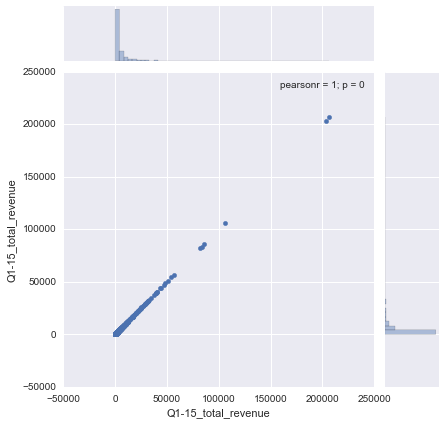

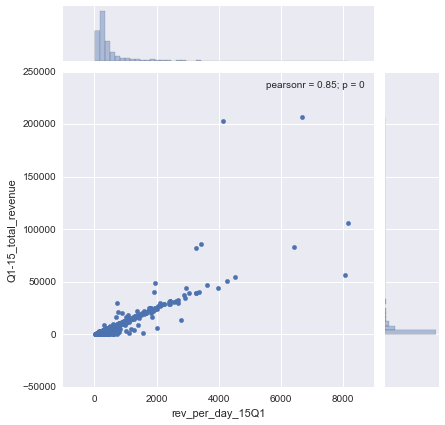

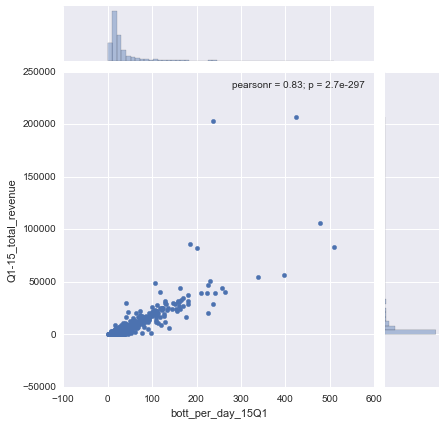

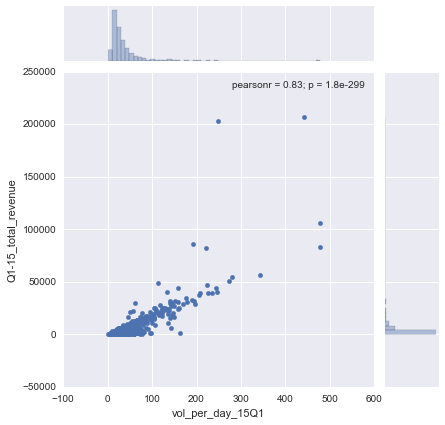

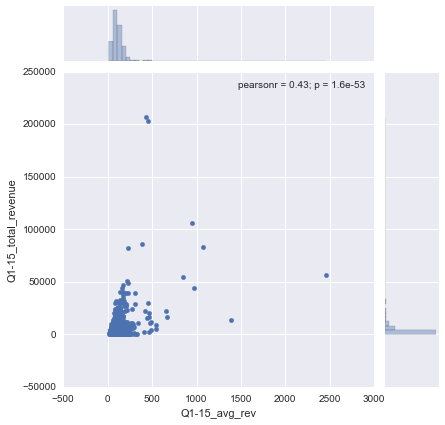

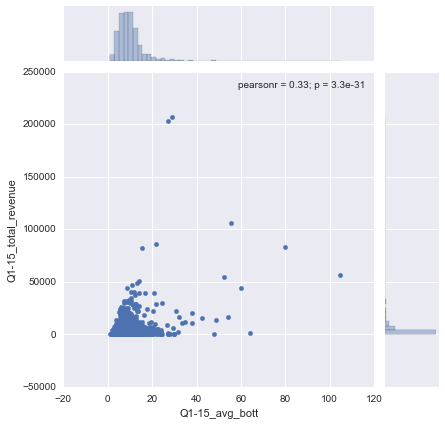

In [121]:
metrics_sub_15Q1 = ['Q1-15_total_revenue', 'rev_per_day_15Q1',
       'bott_per_day_15Q1', 'vol_per_day_15Q1', 'Q1-15_avg_rev', 'Q1-15_avg_bott']
for metric in metrics_sub_15Q1:
    sns.jointplot(x=stores_df[metric], y=stores_df['Q1-15_total_revenue'])

# Build Models

### Base Model

In [126]:
# Create a base model from stores_idf to predict 2015 Q2-Q4 sales from Q1 sales

y = stores_df['2015-Q2-Q4_rev']
X = pd.DataFrame(stores_df['Q1-15_total_revenue'])

lm = linear_model.LinearRegression()
base_model = lm.fit(X,y)

print 'Coef:', base_model.coef_
print 'Intercept:', base_model.intercept_
print "Score (R2):", base_model.score(X, y) 
print "MSE:", mean_squared_error(y, base_model.predict(X))

Coef: [ 3.46972483]
Intercept: 721.38063466
Score (R2): 0.945449500131
MSE: 98106140.133


In [127]:
# Cross validate base model (folds = 5)
print "Cross_Val_Score R2:", cross_val_score(lm, X, y, cv=5)
print "Mean_Cross_Val_Score  R2:", cross_val_score(lm, X, y, cv=5).mean()

Cross_Val_Score R2: [ 0.96248933  0.91725016  0.82798944  0.37006993  0.2173173 ]
Mean_Cross_Val_Score  R2: 0.659023233734


In [128]:
# Cross validate base model with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

lm = linear_model.LinearRegression()

tts_base_model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print "Train_Test_Split R2:", tts_base_model.score(X_test, y_test) 

Train_Test_Split R2: 0.964557791977


### Base model predictions (Q2-Q4 2015 sales) from Q1 sales results:
* Base model R2: 0.946
* Base model MSE: 98,106,140.133 
* Cross val score R2 (5 folds): 0.659
* Train test split R2: 0.966

## Updated base model

In [129]:
print metrics_sub_15Q1

['Q1-15_total_revenue', 'rev_per_day_15Q1', 'bott_per_day_15Q1', 'vol_per_day_15Q1', 'Q1-15_avg_rev', 'Q1-15_avg_bott']


In [197]:
stores_df.columns

Index([u'store', u'city', u'county', u'zip_code', u'days_open_15',
       u'2015_total_rev', u'2015_bottles_sold', u'2015_vol_sold',
       u'2015_rev_per_day', u'2015_bott_per_day', u'2015_vol_per_day',
       u'2015_avg_rev', u'2015_avg_bott_sold', u'2015_avg_vol',
       u'2015_avg_price_per_ml', u'2015_avg_profit_per_ml',
       u'2015_avg_profit_per_bottle', u'days_open_15Q1',
       u'Q1-15_total_revenue', u'Q1-15_bott', u'Q1-15_vol',
       u'rev_per_day_15Q1', u'bott_per_day_15Q1', u'vol_per_day_15Q1',
       u'Q1-15_avg_rev', u'Q1-15_avg_bott', u'Q1-15_avg_vol',
       u'Q1-15_avg_price_per_ml', u'Q1-15_avg_profit_per_ml',
       u'Q1-15_avg_profit_per_bottle', u'days_open_16Q1',
       u'Q1-16_total_revenue', u'Q1-16_bott', u'Q1-16_vol',
       u'rev_per_day_16Q1', u'bott_per_day_16Q1', u'vol_per_day_16Q1',
       u'Q1-16_avg_rev', u'Q1-16_avg_bott', u'Q1-16_avg_vol',
       u'Q1-16_avg_price_per_ml', u'Q1-16_avg_profit_per_ml',
       u'Q1-16_avg_profit_per_bottle', u'2015-Q

In [309]:
# Update base model to predict 2015 Q2-Q4 sales from Q1 sales, vol per day, 

y = stores_df['2015-Q2-Q4_rev']
X = pd.DataFrame(stores_df[['Q1-15_total_revenue', 'bott_per_day_15Q1', \
                            'rev_per_day_15Q1', \
                            'Q1-15_bott', 'vol_per_day_15Q1']])

lm = linear_model.LinearRegression()
base_model = lm.fit(X,y)

print 'Coef:', base_model.coef_
print 'Intercept:', base_model.intercept_
print "Score (R2):", base_model.score(X, y) 
print "MSE:", mean_squared_error(y, base_model.predict(X))

Coef: [   1.10918267 -595.45083759   30.80707932   41.71809867   29.56336139]
Intercept: 2113.38137364
Score (R2): 0.948894122157
MSE: 91911172.6804


In [310]:
# Cross validate updated base model (folds = 5)
print "Cross_Val_Score R2:", cross_val_score(lm, X, y, cv=5)
print "Mean_Cross_Val_Score  R2:", cross_val_score(lm, X, y, cv=5).mean()

# Cross validate base model with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
lm = linear_model.LinearRegression()
tts_base_model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print "Train_Test_Split R2:", tts_base_model.score(X_test, y_test) 

Cross_Val_Score R2: [ 0.9560539   0.92229893  0.80419942  0.43244325 -1.15453712]
Mean_Cross_Val_Score  R2: 0.392091676579
Train_Test_Split R2: 0.918787133285


In [311]:
# Test if lasso model performs better
lasso = linear_model.Lasso(alpha=0.5)
lasso_model = lasso.fit(X, y)
lasso_r2 =  r2_score(y_true=y, y_pred=lasso_model.predict(X))
print "Lasso R2:",lasso_r2
print "Cross_Val_Mean R2:", cross_val_score(lasso, X, y, n_jobs=1, cv=10).mean()

Lasso R2: 0.948882955725
Cross_Val_Mean R2: 0.337570186175


### Updated base model predictions (Q2-Q4 2015 sales) from Q1 sales results:
* Base model R2: 0.947
* Base model MSE: 95,110,822.012 
* Cross val score R2 (5 folds): 0.642
* Train test split R2: 0.924

[(0, 300000),
 (0, 300000),

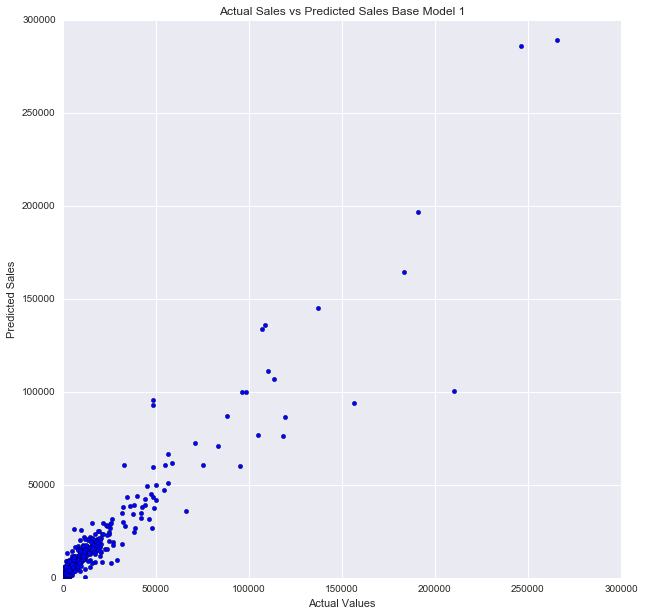

In [303]:
predictions = lm.predict(X_test)

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, predictions)
ax.set(xlabel = 'Actual Values', ylabel= 'Predicted Sales', \
       xlim=[0,300000],ylim=[0,300000], \
       title = 'Actual Sales vs Predicted Sales Base Model 1')

### Updated base model 2|

In [136]:
# Create df for top 10 cities by population
top_ten_cities = ['DES MOINES', 'CEDAR RAPIDS', 'DAVENPORT', 'SIOUX CITY', 'IOWA CITY', \
'WATERLOO', 'COUNCIL BLUFFS', 'AMES', 'WEST DES MOINES', 'DUBUQUE']

def cities(i):
    if i in top_ten_cities:
        return 1
    else:
        return 0

stores_df['top_ten_city'] = stores_df['city'].map(cities)
print sum(stores_df['top_ten_city'])

top_df = stores_df[stores_df['top_ten_city'] == 1]
print sum(top_df['2015_total_rev'])
print sum(top_df['2015_total_rev']) / sum(stores_df['2015_total_rev'])
print 'The top ten cities accounted for 48% of alcohol sales.'

373
13128182.02
0.477716318989
The top ten cities accounted for 48% of alcohol sales.


In [262]:
# Update base model to predict 2015 Q2-Q4 sales from Q1 sales, vol per day AND top ten cities

y = stores_df['2015-Q2-Q4_rev']
X = pd.DataFrame(stores_df[['Q1-15_total_revenue', 'bott_per_day_15Q1', 'rev_per_day_15Q1', \
                            'Q1-15_bott', 'vol_per_day_15Q1', 'top_ten_city']])

lm = linear_model.LinearRegression()
base_model = lm.fit(X,y)

print 'Coef:', base_model.coef_
print 'Intercept:', base_model.intercept_
print "Score (R2):", base_model.score(X, y) 
print "MSE:", mean_squared_error(y, base_model.predict(X))

Coef: [   1.09987166 -599.93979415   30.93106759   41.87525812   32.49263654
 -260.96241803]
Intercept: 2167.62639652
Score (R2): 0.94890127494
MSE: 91898308.7854


In [263]:
# Cross validate updated base model (folds = 5)
print "Cross_Val_Score R2:", cross_val_score(lm, X, y, cv=5)
print "Mean_Cross_Val_Score  R2:", cross_val_score(lm, X, y, cv=5).mean()

# Cross validate base model with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
lm = linear_model.LinearRegression()
tts_base_model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print "Train_Test_Split R2:", tts_base_model.score(X_test, y_test) 

Cross_Val_Score R2: [ 0.95580185  0.92149742  0.80425263  0.43270102 -1.16460052]
Mean_Cross_Val_Score  R2: 0.389930480624
Train_Test_Split R2: 0.865586473962


In [264]:
# Test if lasso model performs better
lasso = linear_model.Lasso(alpha=0.5)
lasso_model = lasso.fit(X, y)
lasso_r2 =  r2_score(y_true=y, y_pred=lasso_model.predict(X))
print "Lasso R2:",lasso_r2
print "Cross_Val_Mean R2:", cross_val_score(lasso, X, y, n_jobs=1, cv=10).mean()

Lasso R2: 0.948889722593
Cross_Val_Mean R2: 0.335268647073


In [265]:
# Test if tts model performs better
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.33)
lasso_train= lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)
print "Train_Test_Split Lasso Model Score:", lasso_train.score(X_test, y_test) 

Train_Test_Split Lasso Model Score: 0.921728544651


[(0, 300000),
 (0, 300000),

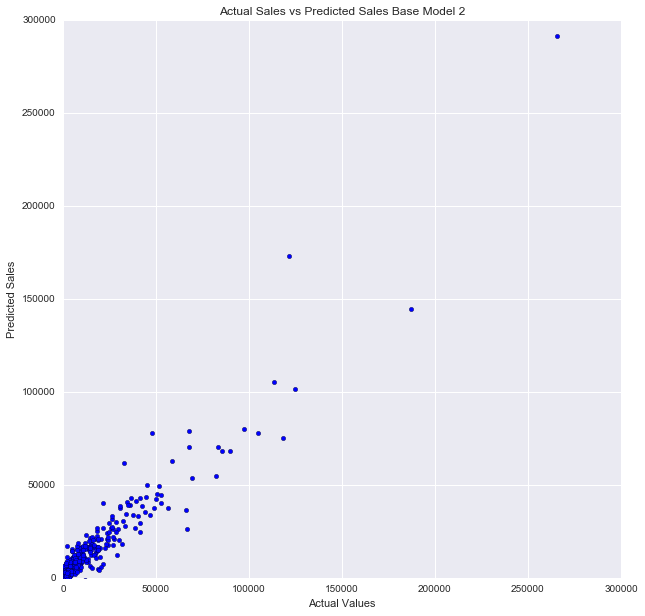

In [266]:
predictions = lm.predict(X_test)

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, predictions)
ax.set(xlabel = 'Actual Values', ylabel= 'Predicted Sales', \
       xlim=[0,300000],ylim=[0,300000], \
       title = 'Actual Sales vs Predicted Sales Base Model 2')

### Updated base model 3

In [267]:
# Update base model to predict 2015 Q2-Q4 sales from Q1 sales, vol per day AND top ten cities

y = stores_df['2015-Q2-Q4_rev']
X = pd.DataFrame(stores_df[['Q1-15_total_revenue', 'bott_per_day_15Q1', 'rev_per_day_15Q1', \
                            'vol_per_day_15Q1']])

lm = linear_model.LinearRegression()
base_model = lm.fit(X,y)

print 'Coef:', base_model.coef_
print 'Intercept:', base_model.intercept_
print "Score (R2):", base_model.score(X, y) 
print "MSE:", mean_squared_error(y, base_model.predict(X))

# Cross validate updated base model (folds = 5)
print "Mean_Cross_Val_Score  R2:", cross_val_score(lm, X, y, cv=5).mean()

# Cross validate base model with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
lm = linear_model.LinearRegression()
tts_base_model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print "Train_Test_Split R2:", tts_base_model.score(X_test, y_test) 

# Test if lasso model performs better
lasso = linear_model.Lasso(alpha=0.5)
lasso_model = lasso.fit(X, y)
lasso_r2 =  r2_score(y_true=y, y_pred=lasso_model.predict(X))
print "Lasso R2:",lasso_r2
print "Cross_Val_Mean R2:", cross_val_score(lasso, X, y, n_jobs=1, cv=10).mean()

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.33)
lasso_train= lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)
print "Train_Test_Split Lasso Model Score:", lasso_train.score(X_test, y_test) 

Coef: [   3.56599727 -157.39631617    6.49389639   23.87596211]
Intercept: 1521.62396938
Score (R2): 0.947156702974
MSE: 95035827.6378
Mean_Cross_Val_Score  R2: 0.636068734731
Train_Test_Split R2: 0.967611867911
Lasso R2: 0.94715670297
Cross_Val_Mean R2: 0.485779758311
Train_Test_Split Lasso Model Score: 0.929285609727


[(0, 300000),
 (0, 300000),

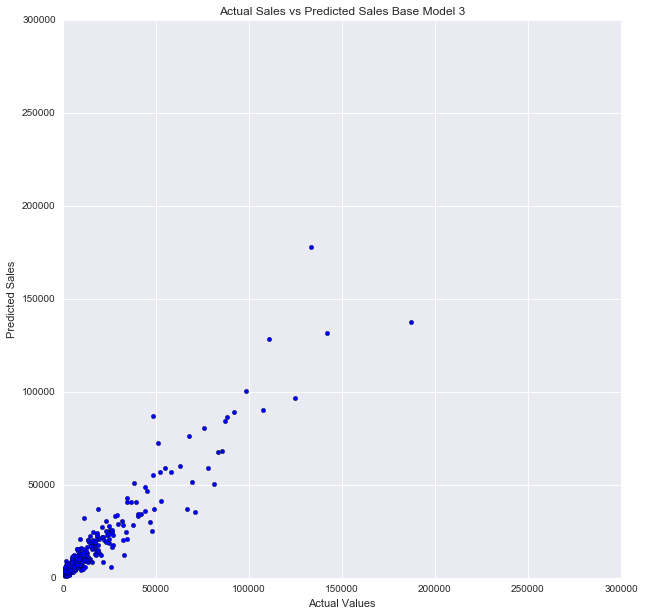

In [268]:
predictions = lm.predict(X_test)

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, predictions)
ax.set(xlabel = 'Actual Values', ylabel= 'Predicted Sales', \
       xlim=[0,300000],ylim=[0,300000], \
       title = 'Actual Sales vs Predicted Sales Base Model 3')

# Make Predictions

In [341]:
# Final model (3rd updated model from above)
y = stores_df['2015-Q2-Q4_rev']
X = stores_df[['Q1-15_total_revenue', 'bott_per_day_15Q1', 'rev_per_day_15Q1', \
                            'vol_per_day_15Q1', '2015_bottles_sold']]

lm = linear_model.LinearRegression()
final_model = lm.fit(X,y)

print "Coef:", final_model.coef_
print "Inercept:", final_model.intercept_
print "Score:", final_model.score(X, y) 
print "MSE:", mean_squared_error(y, final_model.predict(X))

print "Mean cross-val R2:", cross_val_score(lm, X, y, cv=5).mean()

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.33)


lm = linear_model.LinearRegression()

final_model_train = lm.fit(X_train, y_train)

print "Train_Test_Split R2:", final_model_train.score(X_test, y_test) 

print ''
print sum(final_model.predict(X))
final_pred = np.array(final_model.predict(X))
np.transpose(final_pred)

Coef: [ 12.30276387]
Inercept: -1704.7532961
Score: 0.982898543236
MSE: 30756050.2255
Mean cross-val R2: 0.847318116502
Train_Test_Split R2: 0.983116130198

21524094.33


array([   6729.16041997,  119701.75021269,  117876.2661096 , ...,
          -671.32113099,     140.66128446,    -800.50015163])

In [332]:
# Final model alternate (2nd updated model from above)
y = stores_df['2015-Q2-Q4_rev']
X = stores_df[['Q1-15_total_revenue', 'bott_per_day_15Q1', 'rev_per_day_15Q1', \
                            'Q1-15_bott', 'vol_per_day_15Q1', 'top_ten_city']]

lm = linear_model.LinearRegression()
final_model_alt = lm.fit(X,y)

print "Coef:", final_model_alt.coef_
print "Inercept:", final_model_alt.intercept_
print "Score:", final_model_alt.score(X, y) 
print "MSE:", mean_squared_error(y, final_model_alt.predict(X))

print "Mean cross-val R2:", cross_val_score(lm, X, y, cv=5).mean()

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.33)


lm = linear_model.LinearRegression()

final_model_train_alt = lm.fit(X_train, y_train)

print "Train_Test_Split R2:", final_model_train_alt.score(X_test, y_test)

print sum(final_model_alt.predict(X))
final_pred_alt = np.array(final_model_alt.predict(X))
np.transpose(final_pred_alt)
final_12 = sum(final_pred_alt)*10
jj = final_12 - sum(iowa['sales'])
print jj

Coef: [ 3.46972483]
Inercept: 721.38063466
Score: 0.945449500131
MSE: 98106140.133
Mean cross-val R2: 0.659023233734
Train_Test_Split R2: 0.947341208283
21524094.33


array([   6214.40610697,  112655.12006206,  137037.46630541, ...,
          2737.42955069,    1465.84479448,    3259.34555982])

## Create new df with model predictions included

In [342]:
# Create a new df of 2016 data (Q1-16 actual and Q2-Q4-16 predicted rev)

pred_df = stores_df.loc[:,['store','county', 'Q1-16_total_revenue']]
pred_df['base_pred'] = base_pred
pred_df['final_pred'] = final_pred

# Add predictions to actual Q1-16 rev
pred_df['pred_rev_2016_base'] = pred_df['Q1-16_total_revenue'] + pred_df['base_pred']
pred_df['pred_rev_2016_final'] = pred_df['Q1-16_total_revenue'] + pred_df['final_pred']

# Add 2015 rev
pred_df = pred_df.merge(stores_df.loc[:,['store','2015_total_rev', 'Q1-15_total_revenue']], \
                        on = 'store', how="outer")

In [327]:
pred_df.info()
pred_df.fillna(0, inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189 entries, 0 to 1188
Data columns (total 9 columns):
store                  1189 non-null int64
county                 1189 non-null object
Q1-16_total_revenue    1189 non-null float64
base_pred              1189 non-null float64
final_pred             1189 non-null float64
pred_rev_2016_base     1189 non-null float64
pred_rev_2016_final    1189 non-null float64
2015_total_rev         1189 non-null float64
Q1-15_total_revenue    1189 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 92.9+ KB


In [343]:
print'2016 sales predictions from base model:', sum(pred_df['pred_rev_2016_base'])
print '2016 sales predictions from final model:', sum(pred_df['pred_rev_2016_final'])

print '2015 sales:', sum(pred_df['2015_total_rev'])

2016 sales predictions from base model: 27587521.0939
2016 sales predictions from final model: 27594530.6081
2015 sales: 27509124.76


In [324]:
asdf = sum(pred_df['pred_rev_2016_base']) - sum(pred_df['2015_total_rev'])

In [288]:
asdf/sum(pred_df['2015_total_rev']) * 100

0.28498301791858766

In [331]:
final_county_data = pred_df.pivot_table(index=['county'], values = \
                                      ['2015_total_rev','pred_rev_2016_final', 'pred_rev_2016_base'] \
                                      , aggfunc = (np.sum))
final_county_data.reset_index(inplace=True)
final_county_data = final_county_data[final_county_data['county']!=0]
final_county_data.head()

,county,2015_total_rev,pred_rev_2016_base,pred_rev_2016_base
0,Adair,42353.24,46999.497441,46999.497441
1,Adams,10245.14,11372.709969,11372.709969
2,Allamakee,79918.47,70368.177045,70368.177045
3,Appanoose,77033.64,77128.368053,77128.368053
4,Audubon,2869.68,3053.149083,3053.149083


In [352]:
final_county_data.columns = ['county','2016 Predicted Annual Sales', '2015 Sales', \
                             '2016 Q1 Sales',]
final_county_data.iloc[:,1] = final_county_data.iloc[:,1].apply(lambda x: x*10)
final_county_data.iloc[:,2] = final_county_data.iloc[:,2].apply(lambda x: x*10)
final_county_data.iloc[:,3] = final_county_data.iloc[:,3].apply(lambda x: x*10)
print '2016 predicted revenue:', sum(final_county_data['2016 Predicted Annual Sales'])

2016 predicted revenue: 275091247600.0


#### The model predicts 2016 sales will be roughly $295m or 3.8% increase over 2015

In [374]:
pred_by_county = pred_df.pivot_table(index=['county'], values = ['2015_total_rev', \
                                            'pred_rev_2016_final'], aggfunc = (np.sum))
pred_by_county = pred_by_county[(pred_by_county['pred_rev_2016_final']!=0) & \
                               (pred_by_county['pred_rev_2016_final']!=0)]

In [402]:
sum(pred_by_county['2015_Rev'])

27594530.608085558

In [376]:
# Calculate predicted % change in sales from 2015 by county

pred_by_county['perc_change'] = 100*(pred_by_county['pred_rev_2016_final'] / \
                                     pred_by_county['2015_total_rev']-1)
pred_by_county.columns=['Predicted_2016_Rev', '2015_Rev', '%_Change']
pred_by_county.tail()

,Predicted_2016_Rev,2015_Rev,%_Change
county,,,
Winnebago,67091.48,7.815776e+04,16.494317
Winneshiek,118943.94,1.319780e+05,10.958148
Woodbury,994395.39,1.028179e+06,3.397385
Worth,25740.94,3.452484e+04,34.124238
Wright,76552.22,8.073804e+04,5.467927


[<matplotlib.text.Text at 0x1240874d0>, <matplotlib.text.Text at 0x1247fd410>]

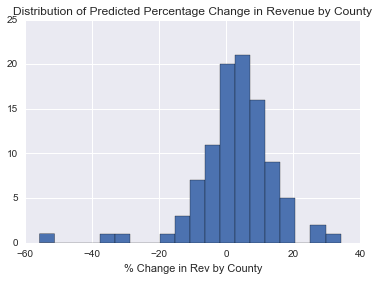

In [380]:
# Plot distribution of predicted year over year change in sales by county

ax = pred_by_county.loc[:,'%_Change'].hist(bins = 20)
ax.set(title = 'Distribution of Predicted Percentage Change in Revenue by County', \
       xlabel = '% Change in Rev by County')

In [381]:
pd.DataFrame(pred_by_county.to_csv("predsales.csv"))

""


In [383]:
pred_by_county.columns

Index([u'Predicted_2016_Rev', u'2015_Rev', u'%_Change'], dtype='object')

0.498353600109


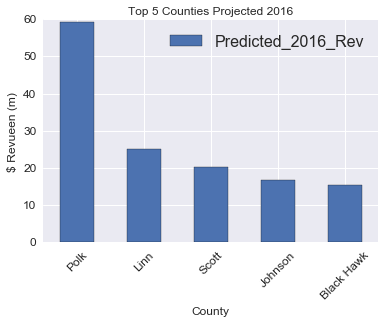

In [400]:
pred_by_county.sort_values('Predicted_2016_Rev', ascending= False, inplace=True)
top_5 = pred_by_county.iloc[:5,:1]
top_5 = top_5.applymap(lambda x: x/100000)

print sum(top_5['Predicted_2016_Rev']) / sum(pred_by_county['Predicted_2016_Rev']) *100000

fig = plt.figure(figsize = (16,20))
ax = top_5.plot(kind = 'bar')
ax.set_title('Top 5 Counties Projected 2016',fontsize = 12)
ax.set_xlabel('County',fontsize = 12) 
ax.set_ylabel('$ Revueen (m)', fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize = 12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
ax.legend(loc=1,prop={'size':16})

plt.show()

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
len(iowa['County'].value_counts())

In [ ]:
iowa_county = pd.pivot_table(iowa, index=iowa['County'], values=['Sale (Dollars)'])
iowa_county.head()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.